# Compare Graph Distributions using MMD as evaluator function

[1] https://github.com/BorgwardtLab/ggme

### Load dependencies, including the graph evaluation library

In [2]:
import sys, os
# Load graph eval library
GRAPH_EVAL_PATH = os.path.abspath('ggme/src/')
sys.path.append(GRAPH_EVAL_PATH)
from evaluate import evaluate_mmd
from correlation import compute_correlation
from metrics.kernels import gaussian_kernel
from metrics.descriptor_functions import degree_distribution, clustering_coefficient, normalised_laplacian_spectrum
# Reset path
sys.path.pop()

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import torch
from torch_geometric.utils import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

### Helper functions to load networkx graphs

In [17]:
from graph_utils import get_dist_grid_codes, get_pyg_graphs, get_networkx_graph, get_cycle_lengths
from out_of_distribution_experiment import get_mmd_test_cases as ood_get_mmd_test_cases
from cross_context_experiment import get_mmd_test_cases as cc_get_mmd_test_cases

### Helper functions to do graph comparisons

In [ ]:
def find_best_sigma(nx_graphs_ref, nx_graphs_eval, desc_func, kernel, sigma_range=(-5,5), **kwargs):
    test_sigmas = [10**x for x in range(*sigma_range)]
    mmds = [evaluate_mmd(
            graphs_dist_1=nx_graphs_ref,
            graphs_dist_2=nx_graphs_eval,
            function=desc_func,
            kernel=kernel,
            use_linear_approximation=False,
            sigma=sigma,
            **kwargs
            ) for sigma in test_sigmas]
    plt.xlabel("sigma")
    plt.xscale("log")
    plt.ylabel("mmd")
    plt.yscale("linear")
    plt.plot(test_sigmas, mmds, '-o', label=desc_func.__name__)
    plt.legend()

    mmd_peak = 0
    sigma_peak = -1
    for sigma, mmd in zip(test_sigmas, mmds):
        if mmd > mmd_peak:
            mmd_peak = mmd
            sigma_peak = sigma

    return (sigma_peak, mmd_peak)

DESCRIPTORS = [ # name, func, sigma
    ('degree', degree_distribution, 1e0),
    ('laplacian', normalised_laplacian_spectrum, 1e0),
]

def analyze_graphs(nx_graphs_ref, nx_graphs_eval, sigma_range=(-5,5), descriptors=DESCRIPTORS):
    
    sigma_mmd_combinations = []

    for name, descriptor_func, _ in tqdm(descriptors):
        sigma_mmd = find_best_sigma(nx_graphs_ref,
                                nx_graphs_eval,
                                descriptor_func,
                                gaussian_kernel,
                                sigma_range=sigma_range,
                                density=True)
        print(name, '(sigma, mmd): ', sigma_mmd)

    return sigma_mmd_combinations
    

### Load graphs, and evaluate distributions using MMD

In [5]:
OUTPUT_BASE_DIR = 'outputs/2025-01-15_12:39:16/'
ALL_GRIDS = dict([(grid, (0,0)) for grid in get_dist_grid_codes(scenario=1)])
print(ALL_GRIDS)

# Create the NX graphs and fill their indices in ALL_GRIDS
NX_GRAPHS = []
start = 0
for grid in ALL_GRIDS.keys():
    nx_graphs = [get_networkx_graph(pyg_graph) for pyg_graph in get_pyg_graphs(OUTPUT_BASE_DIR, grid)]
    NX_GRAPHS.extend(nx_graphs)
    end = start + len(nx_graphs)
    ALL_GRIDS[grid] = (start, end)
    start = end

{'1-LV-rural1--1-no_sw': (0, 0), '1-LV-rural2--1-no_sw': (0, 0), '1-LV-rural3--1-no_sw': (0, 0), '1-LV-semiurb4--1-no_sw': (0, 0), '1-LV-semiurb5--1-no_sw': (0, 0), '1-LV-urban6--1-no_sw': (0, 0), '1-MV-comm--1-no_sw': (0, 0), '1-MV-rural--1-no_sw': (0, 0), '1-MV-semiurb--1-no_sw': (0, 0), '1-MV-urban--1-no_sw': (0, 0)}


In [6]:
ALL_GRIDS

{'1-LV-rural1--1-no_sw': (0, 300),
 '1-LV-rural2--1-no_sw': (300, 600),
 '1-LV-rural3--1-no_sw': (600, 900),
 '1-LV-semiurb4--1-no_sw': (900, 1200),
 '1-LV-semiurb5--1-no_sw': (1200, 1500),
 '1-LV-urban6--1-no_sw': (1500, 1800),
 '1-MV-comm--1-no_sw': (1800, 2100),
 '1-MV-rural--1-no_sw': (2100, 2400),
 '1-MV-semiurb--1-no_sw': (2400, 2700),
 '1-MV-urban--1-no_sw': (2700, 3000)}

Grids: 1-LV-rural1--1-no_sw vs 1-LV-rural2--1-no_sw
degree (sigma, mmd):  (1000, 1.9999999999999998)
laplacian (sigma, mmd):  (0.1, 1.9999999999999998)


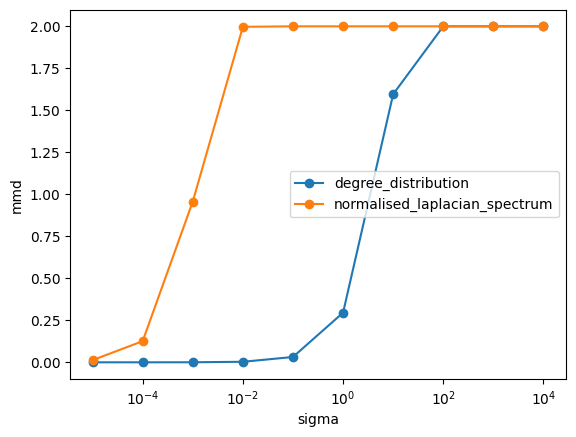

In [7]:
# Test
grid = '1-LV-rural1--1-no_sw'
grid2 = '1-LV-rural2--1-no_sw'
start, end = ALL_GRIDS[grid]
start_2, end_2 = ALL_GRIDS[grid2]
nx_graphs_ref = NX_GRAPHS[start:end]
nx_graphs_eval = NX_GRAPHS[start_2:end_2]
print('Grids:', grid, 'vs', grid2)
analyze_graphs(nx_graphs_ref, nx_graphs_eval)
plt.show(block=False)
print(flush=True)

### Analyze the graphs for the best sigma, using a different reference grid each time

Grids: 1-LV-rural1--1-no_sw vs 1-LV-rural2--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.9999999999999998)


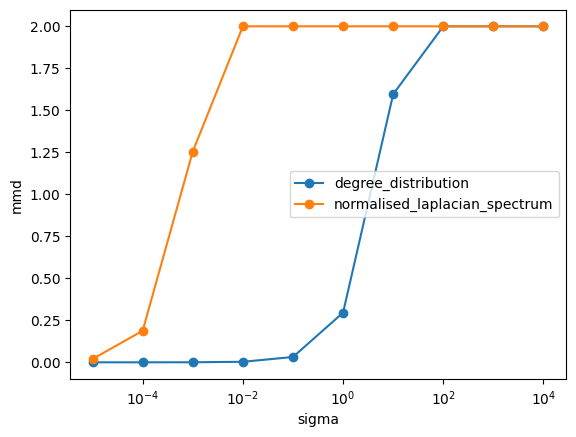


Grids: 1-LV-rural1--1-no_sw vs 1-LV-rural3--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.9999999999999998)


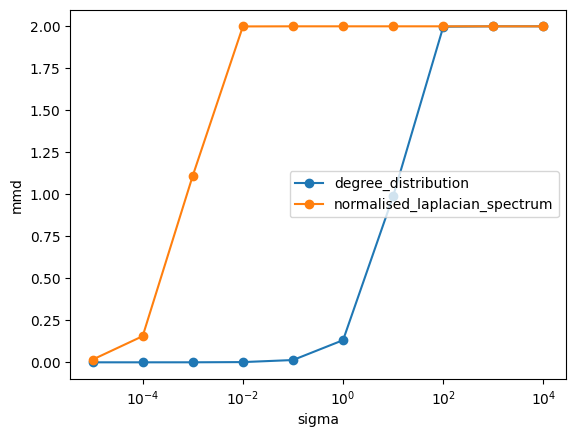


Grids: 1-LV-rural1--1-no_sw vs 1-LV-semiurb4--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.9999999999999998)


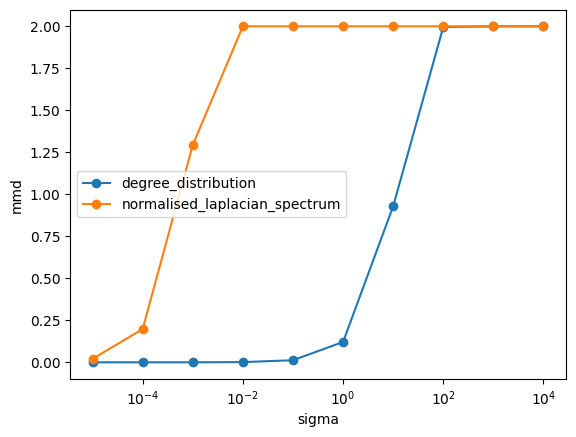


Grids: 1-LV-rural1--1-no_sw vs 1-LV-semiurb5--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.9999999999999998)


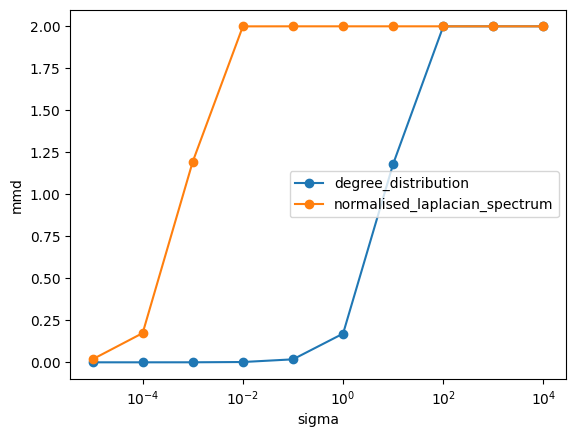


Grids: 1-LV-rural1--1-no_sw vs 1-LV-urban6--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.9999999999999998)


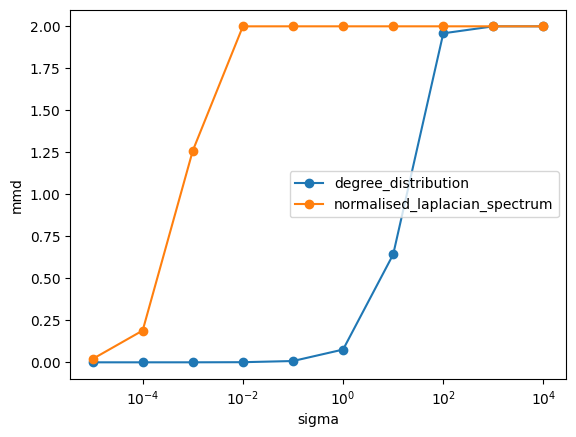


Grids: 1-LV-rural1--1-no_sw vs 1-MV-comm--1-no_sw
Degree Distribution (sigma, mmd):  (100, 1.9737374089173931)
Laplacian Spectrum (sigma, mmd):  (0.01, 1.8037940400675199)


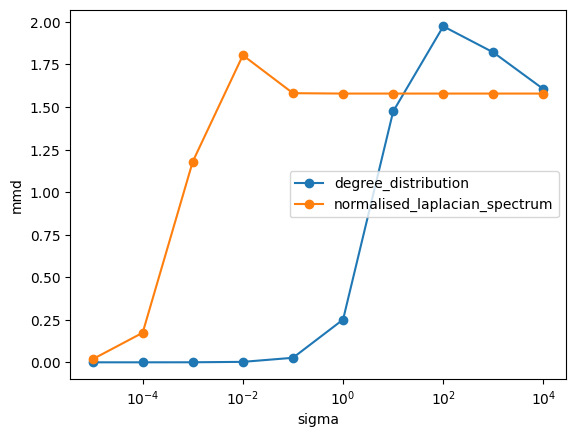


Grids: 1-LV-rural1--1-no_sw vs 1-MV-rural--1-no_sw
Degree Distribution (sigma, mmd):  (100, 1.9940317783295933)
Laplacian Spectrum (sigma, mmd):  (0.01, 1.9321017772072167)


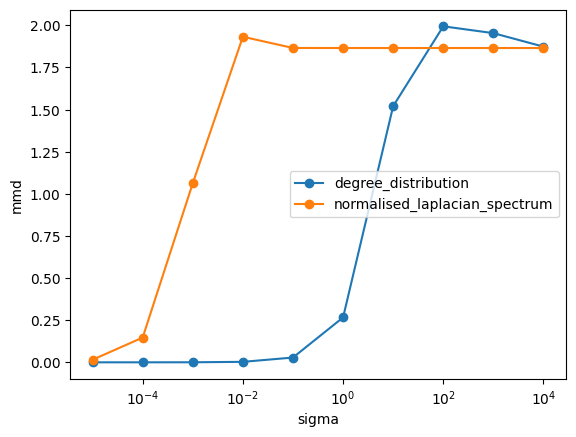


Grids: 1-LV-rural1--1-no_sw vs 1-MV-semiurb--1-no_sw
Degree Distribution (sigma, mmd):  (100, 1.9935914910164816)
Laplacian Spectrum (sigma, mmd):  (0.01, 1.9410244767524154)


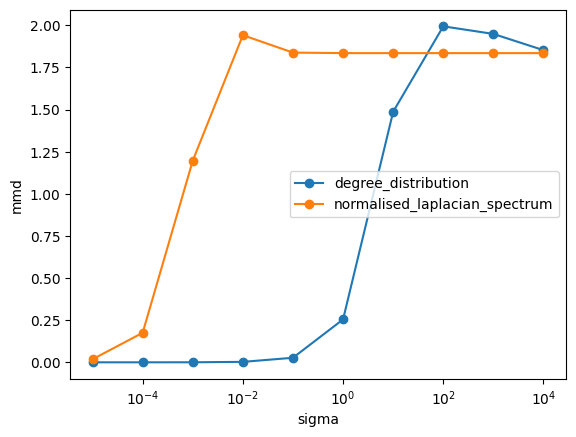


Grids: 1-LV-rural1--1-no_sw vs 1-MV-urban--1-no_sw
Degree Distribution (sigma, mmd):  (100, 1.989814741612791)
Laplacian Spectrum (sigma, mmd):  (0.01, 1.9315444668563684)


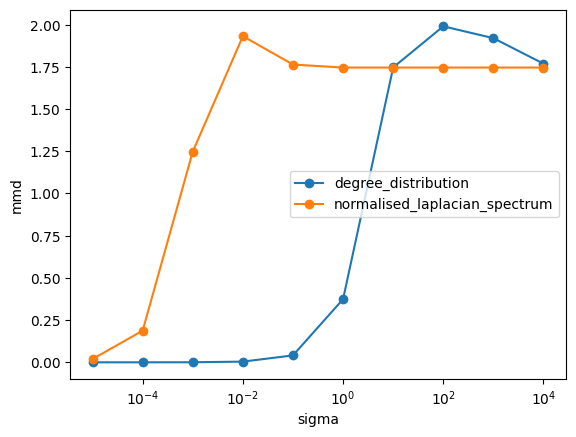


Grids: 1-LV-rural2--1-no_sw vs 1-LV-rural3--1-no_sw
Degree Distribution (sigma, mmd):  (10000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (1, 1.9999999999999998)


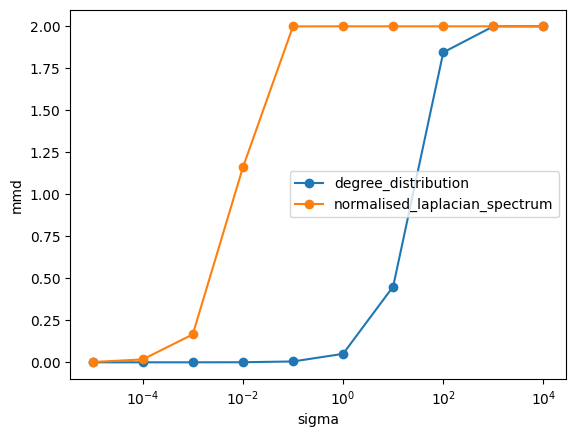


Grids: 1-LV-rural2--1-no_sw vs 1-LV-semiurb4--1-no_sw
Degree Distribution (sigma, mmd):  (10000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (1, 1.9999999999999998)


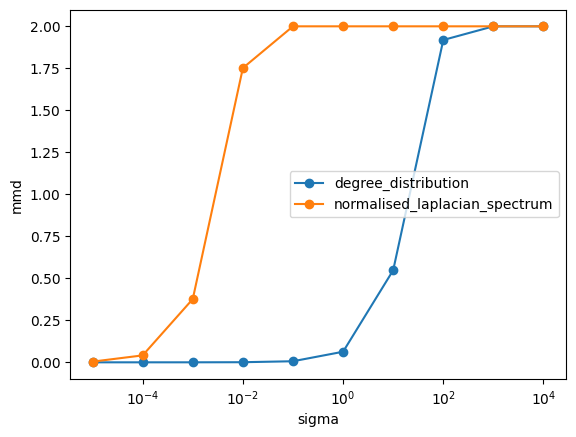


Grids: 1-LV-rural2--1-no_sw vs 1-LV-semiurb5--1-no_sw
Degree Distribution (sigma, mmd):  (10000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (1, 1.9999999999999998)


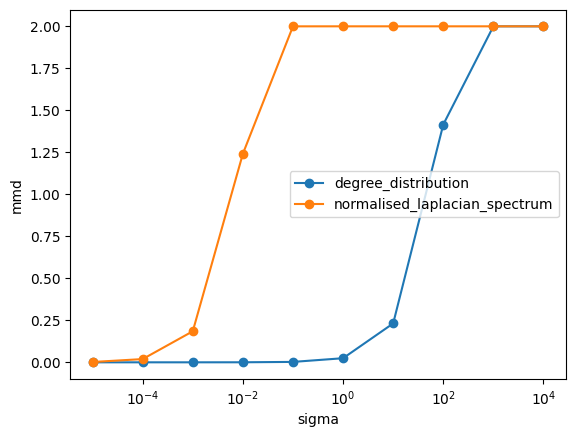


Grids: 1-LV-rural2--1-no_sw vs 1-LV-urban6--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9999999999999998)
Laplacian Spectrum (sigma, mmd):  (1, 1.9999999999999998)


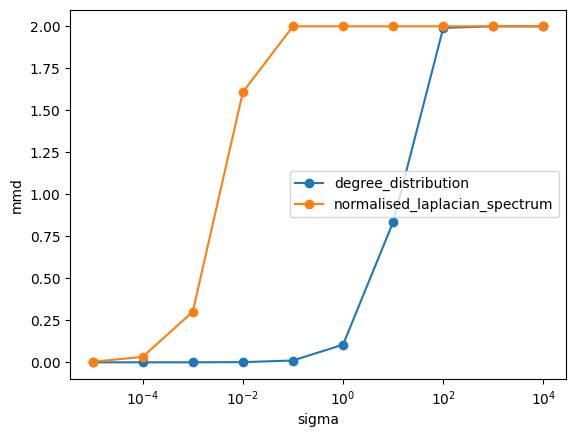


Grids: 1-LV-rural2--1-no_sw vs 1-MV-comm--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.817571867133638)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.5809493847308569)


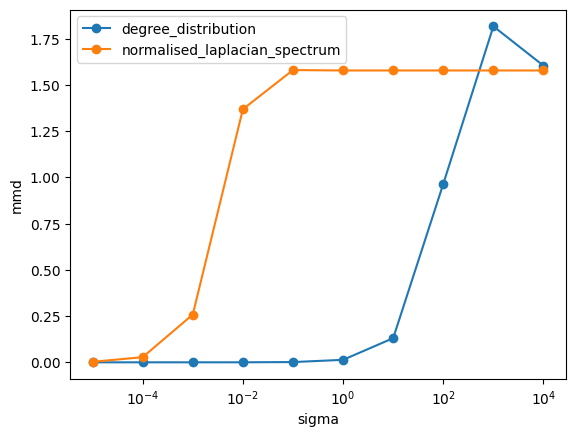


Grids: 1-LV-rural2--1-no_sw vs 1-MV-rural--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9468224677897632)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.8655768912553323)


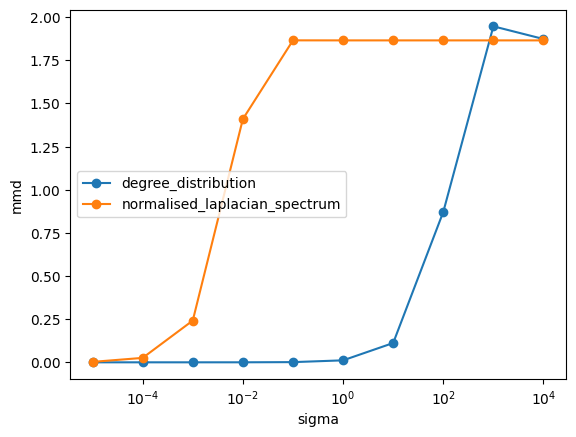


Grids: 1-LV-rural2--1-no_sw vs 1-MV-semiurb--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.947713191042917)
Laplacian Spectrum (sigma, mmd):  (0.1, 1.837657569206293)


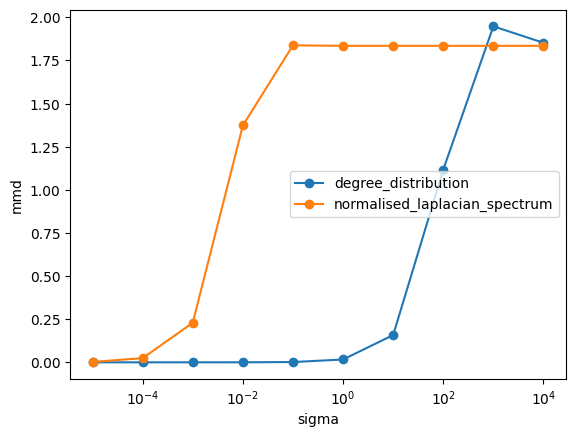


Grids: 1-LV-rural2--1-no_sw vs 1-MV-urban--1-no_sw
Degree Distribution (sigma, mmd):  (1000, 1.9174691827653392)


KeyboardInterrupt: 

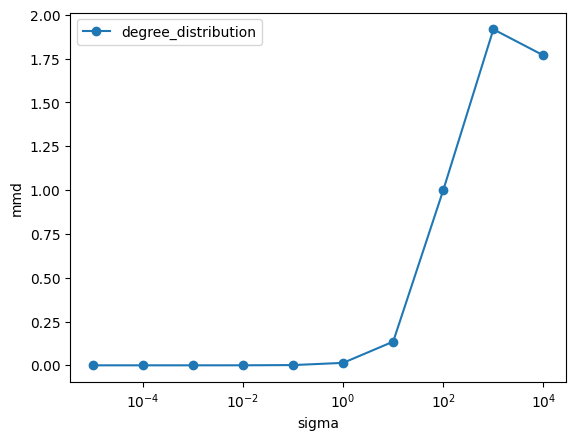

In [12]:
test_cases = ood_get_mmd_test_cases(get_dist_grid_codes(scenario=1))
best_params_deg = []
best_params_lap = []
for train_grid, test_grid in tqdm(test_cases):
    start_train, end_train = ALL_GRIDS[train_grid]
    start_test, end_test = ALL_GRIDS[test_grid]
    nx_graphs_ref = NX_GRAPHS[start_train:end_train]
    nx_graphs_eval = NX_GRAPHS[start_test:end_test]
    print('Grids:', train_grid, 'vs', test_grid)
    params_deg, params_lap = analyze_graphs(nx_graphs_ref, nx_graphs_eval)
    best_params_deg.append(params_deg)
    best_params_lap.append(params_lap)
    plt.show(block=False)
    print(flush=True)

### Conclusion
#### We can use this pipeline to analyze which sigmas work best on average for each descriptor function, based on our data spread. We do not necessarily always choose the sigma with the largest mmd because it flattens out at some point. We choose a relatively high mmd, where there is some activity.

## Appendix

### Generating mmd data

#### OOD

In [18]:
def eval_mmd(graphs_train, graphs_test, descriptor_func, sigma):  
    mmd = evaluate_mmd(
        graphs_dist_1=graphs_train,
        graphs_dist_2=graphs_test,
        function=descriptor_func,
        kernel=gaussian_kernel,
        density=True,
        use_linear_approximation=False,
        sigma=sigma)
    
    return mmd

def create_mmd_df(descriptors, experiment='cc'):
    def get_graphs_cc(test_case):
        train_grid, test_grid = test_case

        start_train, end_train = ALL_GRIDS[train_grid]
        nx_graphs_ref = NX_GRAPHS[start_train:end_train]

        start_test, end_test = ALL_GRIDS[test_grid]
        nx_graphs_eval = NX_GRAPHS[start_test:end_test]

        return nx_graphs_ref, nx_graphs_eval

    def get_graphs_ood(test_case):
        train_grids, target = test_case

        nx_graphs_ref = []
        for grid in train_grids:
            start_train, end_train = ALL_GRIDS[grid]
            nx_graphs_ref.extend(NX_GRAPHS[start_train:end_train])
            
        start_test, end_test = ALL_GRIDS[target]
        nx_graphs_eval = NX_GRAPHS[start_test:end_test]

        return nx_graphs_ref, nx_graphs_eval
    
    if experiment == 'cc':
        test_cases = cc_get_mmd_test_cases(get_dist_grid_codes(scenario=1))
        column_names = ['training_grid', 'testing_grid']
    elif experiment == 'ood':
        test_cases = ood_get_mmd_test_cases(get_dist_grid_codes(scenario=1))
        column_names = ['testing_grid']
    else:
        return None

    results = []
    for test_case in tqdm(test_cases):
        if experiment == 'cc':
            row = [test_case[0], test_case[1]]
            nx_graphs_ref, nx_graphs_eval = get_graphs_cc(test_case)
        else:
            row = [test_case[1]]
            nx_graphs_ref, nx_graphs_eval = get_graphs_ood(test_case)
        
        for _, descriptor_func, sigma in descriptors:
            mmd = eval_mmd(nx_graphs_ref, nx_graphs_eval, descriptor_func, sigma)
            row.append(mmd)
        results.append(row)

    column_names = column_names + [f'mmd_{name}' for name, _, _ in descriptors]
    mmd_df = pd.DataFrame(results, columns=column_names)
    return mmd_df

In [20]:
descriptors = [('degree', degree_distribution, 1e3), ('laplacian', normalised_laplacian_spectrum, 1e-2)]
results_df = create_mmd_df(descriptors, experiment='cc')

  0%|          | 0/45 [00:00<?, ?it/s]

100%|██████████| 45/45 [01:22<00:00,  1.83s/it]


In [23]:
results_df.head()

,training_grid,testing_grid,mmd_degree,mmd_laplacian
0,1-LV-rural1--1-no_sw,1-LV-rural2--1-no_sw,2.0,1.997022
1,1-LV-rural1--1-no_sw,1-LV-rural3--1-no_sw,2.0,1.991608
2,1-LV-rural1--1-no_sw,1-LV-semiurb4--1-no_sw,2.0,1.998903
3,1-LV-rural1--1-no_sw,1-LV-semiurb5--1-no_sw,2.0,1.990122
4,1-LV-rural1--1-no_sw,1-LV-urban6--1-no_sw,2.0,1.997129


In [51]:
# Best params
descriptors = [('degree', degree_distribution, 1e1), ('laplacian', normalised_laplacian_spectrum, 1e-2)]

In [22]:
mmd_df = create_mmd_df(descriptors, experiment='cc')

100%|██████████| 45/45 [01:23<00:00,  1.85s/it]


mmd_degree
Total mmds: 45
Unique mmds: 45


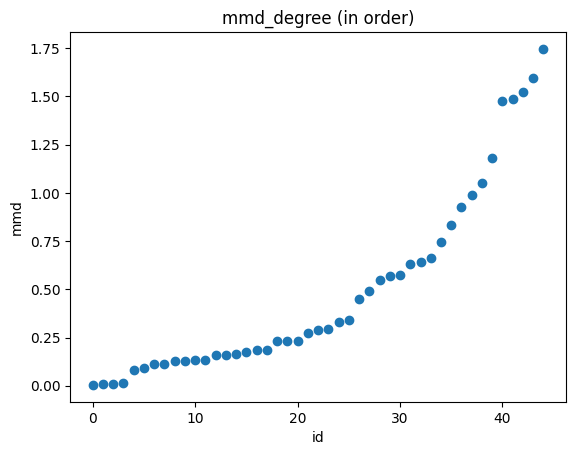

mmd_laplacian
Total mmds: 45
Unique mmds: 45


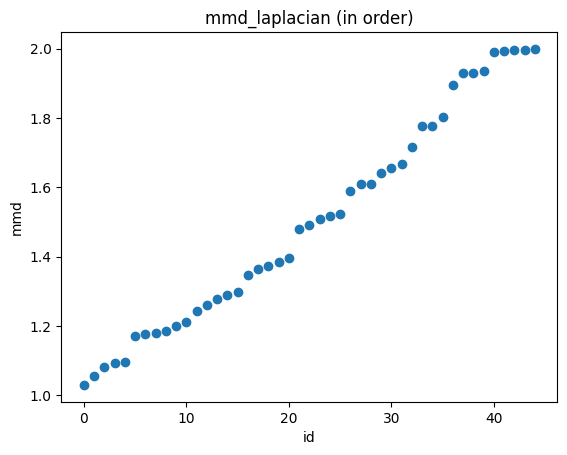

mmd_cycle
Total mmds: 45
Unique mmds: 45


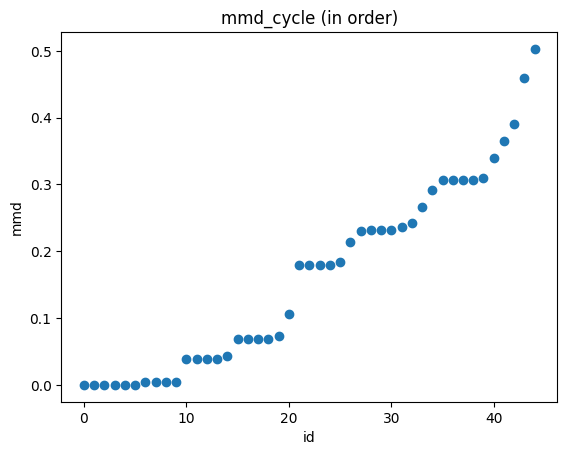

In [52]:
def show_mmd_range(mmd_df, descriptor):
    descriptor = f'mmd_{descriptor}'
    print(descriptor)
    print('Total mmds:', len(mmd_df))
    print('Unique mmds:', len(mmd_df[descriptor].unique()))
    plt.scatter(range(len(mmd_df)), sorted(mmd_df[descriptor].values))
    plt.ylabel('mmd')
    plt.xlabel('id')
    plt.title(f'{descriptor} (in order)')
    plt.show()

for name,_,_ in descriptors:
    show_mmd_range(mmd_df, name)

In [53]:
descriptors = [('cycle', cycle_distribution, 1e-3)]
cycle_df = create_mmd_df(descriptors, experiment='ood')

100%|██████████| 10/10 [02:26<00:00, 14.66s/it]


In [57]:
# (mmd_df.values[:, :2] == cycle_df2.values[:, :2]).all()
OOD_MMD_FILE = 'ood_mmds_data.csv'
ood_mmd_df = pd.read_csv(OOD_MMD_FILE, index_col=0)
ood_mmd_df.head()

,testing_grid,mmd_degree,mmd_laplacian
0,1-LV-rural1--1-no_sw,1.420892,1.334370
1,1-LV-rural2--1-no_sw,0.830893,0.799255
2,1-LV-rural3--1-no_sw,0.680108,0.671751
3,1-LV-semiurb4--1-no_sw,0.755498,1.093082
4,1-LV-semiurb5--1-no_sw,0.736412,0.745036


In [42]:
ah = pd.read_csv('cc_mmds_data.csv', index_col=0)
ah

,training_grid,testing_grid,mmd_degree,mmd_laplacian
0,1-LV-rural1--1-no_sw,1-LV-rural2--1-no_sw,1.596062,1.999897
1,1-LV-rural1--1-no_sw,1-LV-rural3--1-no_sw,0.989157,1.999398
2,1-LV-rural1--1-no_sw,1-LV-semiurb4--1-no_sw,0.929158,1.999940
3,1-LV-rural1--1-no_sw,1-LV-semiurb5--1-no_sw,1.181185,1.999777
4,1-LV-rural1--1-no_sw,1-LV-urban6--1-no_sw,0.642185,1.999903
5,1-LV-rural1--1-no_sw,1-MV-comm--1-no_sw,1.473883,1.803794
6,1-LV-rural1--1-no_sw,1-MV-rural--1-no_sw,1.520498,1.932102
7,1-LV-rural1--1-no_sw,1-MV-semiurb--1-no_sw,1.487087,1.941024
8,1-LV-rural1--1-no_sw,1-MV-urban--1-no_sw,1.746394,1.931544
9,1-LV-rural2--1-no_sw,1-LV-rural3--1-no_sw,0.451244,1.159865


In [47]:
mmd_df.to_csv('cc_mmds_data.csv')

In [10]:
def eval_mmd(graphs_train, graphs_test):
    # Degree Distrubtion
    sigma_degree = 1e3
    mmd_degree = evaluate_mmd(
        graphs_dist_1=graphs_train,
        graphs_dist_2=graphs_test,
        function=degree_distribution,
        kernel=gaussian_kernel,
        density=True,
        use_linear_approximation=False,
        sigma=sigma_degree)

    # Laplacian Spectrum
    sigma_laplacian = 1e-2
    mmd_laplacian = evaluate_mmd(
        graphs_dist_1=graphs_train,
        graphs_dist_2=graphs_test,
        function=normalised_laplacian_spectrum,
        kernel=gaussian_kernel,
        density=True,
        use_linear_approximation=False,
        sigma=sigma_laplacian)
    
    return mmd_degree, mmd_laplacian

test_cases = ood_get_mmd_test_cases(get_dist_grid_codes(scenario=1))
results = []
for train_grids, target in tqdm(test_cases):
    nx_graphs_ref = []
    for grid in train_grids:
        start_train, end_train = ALL_GRIDS[grid]
        nx_graphs_ref.extend(NX_GRAPHS[start_train:end_train])
        
    start_test, end_test = ALL_GRIDS[target]
    nx_graphs_eval = NX_GRAPHS[start_test:end_test]
    
    print('Target grid:', target)
    mmd_degree, mmd_laplacian = eval_mmd(nx_graphs_ref, nx_graphs_eval)
    results.append((
        target,
        mmd_degree,
        mmd_laplacian
    ))

column_names = [
    'testing_grid',
    'mmd_degree',
    'mmd_laplacian'
]
results_df = pd.DataFrame(results, columns=column_names)

  0%|          | 0/10 [00:00<?, ?it/s]

Target grid: 1-LV-rural1--1-no_sw


 10%|█         | 1/10 [03:11<28:43, 191.46s/it]

Target grid: 1-LV-rural2--1-no_sw


 20%|██        | 2/10 [06:13<24:45, 185.72s/it]

Target grid: 1-LV-rural3--1-no_sw


 30%|███       | 3/10 [09:12<21:20, 182.91s/it]

Target grid: 1-LV-semiurb4--1-no_sw


 40%|████      | 4/10 [12:03<17:48, 178.16s/it]

Target grid: 1-LV-semiurb5--1-no_sw


 50%|█████     | 5/10 [14:56<14:40, 176.10s/it]

Target grid: 1-LV-urban6--1-no_sw


 60%|██████    | 6/10 [17:55<11:48, 177.21s/it]

Target grid: 1-MV-comm--1-no_sw


 70%|███████   | 7/10 [20:47<08:46, 175.62s/it]

Target grid: 1-MV-rural--1-no_sw


 80%|████████  | 8/10 [23:44<05:51, 175.89s/it]

Target grid: 1-MV-semiurb--1-no_sw


 90%|█████████ | 9/10 [26:38<02:55, 175.49s/it]

Target grid: 1-MV-urban--1-no_sw


100%|██████████| 10/10 [29:31<00:00, 177.19s/it]


In [11]:
results_df.to_csv('ood_mmds_deg_1e3_lap_1e-2.csv')

In [12]:
def eval_mmd(graphs_train, graphs_test):
    # Degree Distrubtion
    sigma_degree = 1e1
    mmd_degree = evaluate_mmd(
        graphs_dist_1=graphs_train,
        graphs_dist_2=graphs_test,
        function=degree_distribution,
        kernel=gaussian_kernel,
        density=True,
        use_linear_approximation=False,
        sigma=sigma_degree)

    # Laplacian Spectrum
    sigma_laplacian = 1e-3
    mmd_laplacian = evaluate_mmd(
        graphs_dist_1=graphs_train,
        graphs_dist_2=graphs_test,
        function=normalised_laplacian_spectrum,
        kernel=gaussian_kernel,
        density=True,
        use_linear_approximation=False,
        sigma=sigma_laplacian)
    
    return mmd_degree, mmd_laplacian

test_cases = ood_get_mmd_test_cases(get_dist_grid_codes(scenario=1))
results = []
for train_grids, target in tqdm(test_cases):
    nx_graphs_ref = []
    for grid in train_grids:
        start_train, end_train = ALL_GRIDS[grid]
        nx_graphs_ref.extend(NX_GRAPHS[start_train:end_train])
        
    start_test, end_test = ALL_GRIDS[target]
    nx_graphs_eval = NX_GRAPHS[start_test:end_test]
    
    print('Target grid:', target)
    mmd_degree, mmd_laplacian = eval_mmd(nx_graphs_ref, nx_graphs_eval)
    results.append((
        target,
        mmd_degree,
        mmd_laplacian
    ))

column_names = [
    'testing_grid',
    'mmd_degree',
    'mmd_laplacian'
]
results_df = pd.DataFrame(results, columns=column_names)

  0%|          | 0/10 [00:00<?, ?it/s]

Target grid: 1-LV-rural1--1-no_sw


 10%|█         | 1/10 [02:48<25:19, 168.87s/it]

Target grid: 1-LV-rural2--1-no_sw


 20%|██        | 2/10 [05:44<23:01, 172.72s/it]

Target grid: 1-LV-rural3--1-no_sw


 30%|███       | 3/10 [08:25<19:32, 167.57s/it]

Target grid: 1-LV-semiurb4--1-no_sw


 40%|████      | 4/10 [11:19<17:00, 170.16s/it]

Target grid: 1-LV-semiurb5--1-no_sw


 50%|█████     | 5/10 [14:17<14:24, 172.93s/it]

Target grid: 1-LV-urban6--1-no_sw


 60%|██████    | 6/10 [17:29<11:58, 179.50s/it]

Target grid: 1-MV-comm--1-no_sw


 70%|███████   | 7/10 [20:24<08:53, 177.89s/it]

Target grid: 1-MV-rural--1-no_sw


 80%|████████  | 8/10 [23:15<05:51, 175.60s/it]

Target grid: 1-MV-semiurb--1-no_sw


 90%|█████████ | 9/10 [26:01<02:52, 172.65s/it]

Target grid: 1-MV-urban--1-no_sw


100%|██████████| 10/10 [29:03<00:00, 174.32s/it]


In [13]:
results_df.to_csv('ood_mmds_deg_1e1_lap_1e-3.csv')

In [14]:
def eval_mmd(graphs_train, graphs_test):
    # Degree Distrubtion
    sigma_degree = 1e2
    mmd_degree = evaluate_mmd(
        graphs_dist_1=graphs_train,
        graphs_dist_2=graphs_test,
        function=degree_distribution,
        kernel=gaussian_kernel,
        density=True,
        use_linear_approximation=False,
        sigma=sigma_degree)

    # Laplacian Spectrum
    sigma_laplacian = 1e-1
    mmd_laplacian = evaluate_mmd(
        graphs_dist_1=graphs_train,
        graphs_dist_2=graphs_test,
        function=normalised_laplacian_spectrum,
        kernel=gaussian_kernel,
        density=True,
        use_linear_approximation=False,
        sigma=sigma_laplacian)
    
    return mmd_degree, mmd_laplacian

test_cases = ood_get_mmd_test_cases(get_dist_grid_codes(scenario=1))
results = []
for train_grids, target in tqdm(test_cases):
    nx_graphs_ref = []
    for grid in train_grids:
        start_train, end_train = ALL_GRIDS[grid]
        nx_graphs_ref.extend(NX_GRAPHS[start_train:end_train])
        
    start_test, end_test = ALL_GRIDS[target]
    nx_graphs_eval = NX_GRAPHS[start_test:end_test]
    
    print('Target grid:', target)
    mmd_degree, mmd_laplacian = eval_mmd(nx_graphs_ref, nx_graphs_eval)
    results.append((
        target,
        mmd_degree,
        mmd_laplacian
    ))

column_names = [
    'testing_grid',
    'mmd_degree',
    'mmd_laplacian'
]
results_df = pd.DataFrame(results, columns=column_names)

  0%|          | 0/10 [00:00<?, ?it/s]

Target grid: 1-LV-rural1--1-no_sw


 10%|█         | 1/10 [02:52<25:55, 172.80s/it]

Target grid: 1-LV-rural2--1-no_sw


 20%|██        | 2/10 [05:42<22:50, 171.26s/it]

Target grid: 1-LV-rural3--1-no_sw


 30%|███       | 3/10 [08:37<20:08, 172.65s/it]

Target grid: 1-LV-semiurb4--1-no_sw


 40%|████      | 4/10 [11:29<17:13, 172.32s/it]

Target grid: 1-LV-semiurb5--1-no_sw


 50%|█████     | 5/10 [14:25<14:28, 173.79s/it]

Target grid: 1-LV-urban6--1-no_sw


 60%|██████    | 6/10 [17:13<11:26, 171.70s/it]

Target grid: 1-MV-comm--1-no_sw


 70%|███████   | 7/10 [20:06<08:37, 172.37s/it]

Target grid: 1-MV-rural--1-no_sw


 80%|████████  | 8/10 [22:49<05:38, 169.42s/it]

Target grid: 1-MV-semiurb--1-no_sw


 90%|█████████ | 9/10 [25:41<02:49, 169.94s/it]

Target grid: 1-MV-urban--1-no_sw


100%|██████████| 10/10 [28:42<00:00, 172.29s/it]


In [15]:
results_df.to_csv('ood_mmds_deg_1e2_lap_1e-1.csv')

### Clustering Coefficient as descriptor function

Clustering coefficient converges to zero for radial distribution feeders due to their tree structures, and in general there is not much difference using clustering coefficient as a descriptor. This can be shown with the distance of 0 for all sigmas.

(-1, 0)

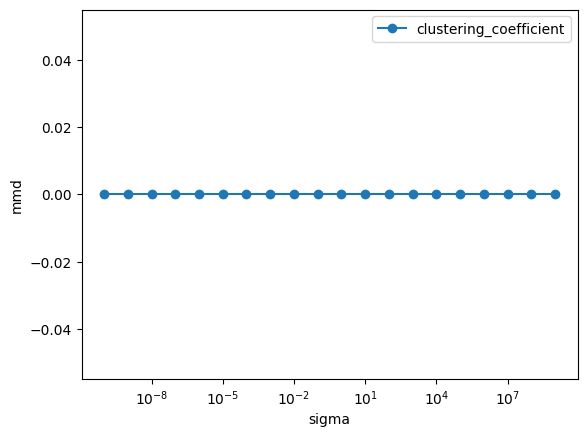

In [48]:
nx_graphs_ref = NX_GRAPHS[0:15]
nx_graphs_eval = NX_GRAPHS[1:]
find_best_sigma(nx_graphs_ref,
                nx_graphs_eval,
                clustering_coefficient,
                gaussian_kernel,
                density=True)

### Cycles as descriptor function

In [1]:
def cycle_distribution(G, density=False, **kwargs):
    cycles = get_cycle_lengths(G)
    hist, _ = np.histogram(
        cycles, bins=G.number_of_nodes(), density=density
    )

    return hist

Grids: 1-LV-rural1--1-no_sw vs 1-LV-rural2--1-no_sw
cycles (sigma, mmd):  (0.01, 1.9999999999999998)


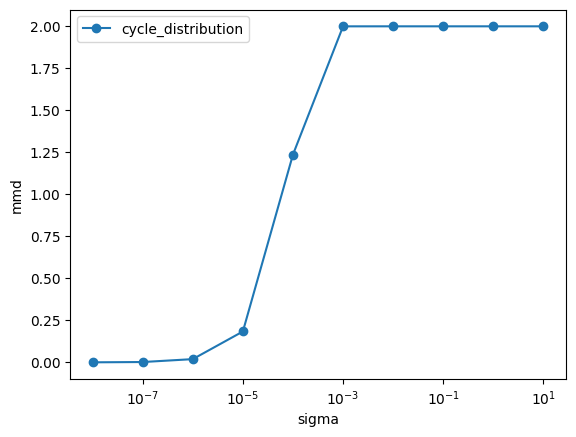

In [13]:
# Test CC
grid = '1-LV-rural1--1-no_sw'
grid2 = '1-LV-rural2--1-no_sw'
start, end = ALL_GRIDS[grid]
start_2, end_2 = ALL_GRIDS[grid2]
nx_graphs_ref = NX_GRAPHS[start:end]
nx_graphs_eval = NX_GRAPHS[start_2:end_2]
print('Grids:', grid, 'vs', grid2)
analyze_graphs(nx_graphs_ref, nx_graphs_eval, sigma_range=(-8, 2), descriptors=[('cycles', cycle_distribution)])
plt.show(block=False)
print(flush=True)

Target Grid: 1-LV-rural1--1-no_sw
cycles (sigma, mmd):  (0.1, 1.219873096649638)


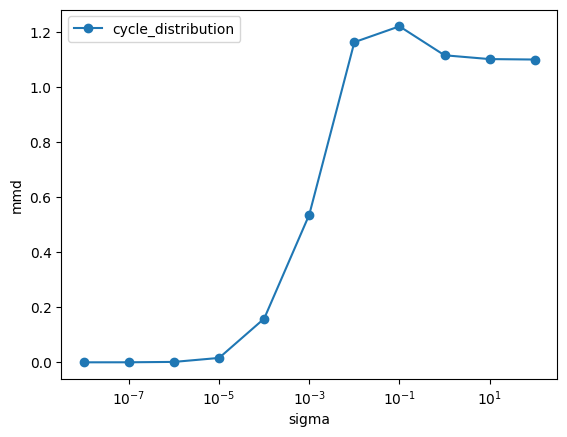

In [48]:
# Test OOD
target = '1-LV-rural1--1-no_sw'
start, end = ALL_GRIDS[target]
nx_graphs_ref = NX_GRAPHS[:start] + NX_GRAPHS[end:]
nx_graphs_eval = NX_GRAPHS[start:end]
print('Target Grid:', target)
analyze_graphs(nx_graphs_ref, nx_graphs_eval, sigma_range=(-8, 3), descriptors=[('cycles', cycle_distribution, 0)])
plt.show(block=False)
print(flush=True)

### Testing correlations with MMD

We want to test correlations. Here we just correlate the test sigmas to the MMD, just to see how the function works, but usually we would correlate the RMSEs and the MMDs.  
We use both the Pearson and the Spearman correlation.  
The main difference between Pearson and Spearman correlation is that Pearson assumes a linear relationship between data, while Spearman checks for a monotonic relationship (when one variable increases or decreases as the other variable does, but does not necessarily have to be a linear increase).

In [ ]:
def correlate(nx_graphs_ref, nx_graphs_eval, desc_func, kernel, **kwargs):
    test_sigmas = [10**x for x in range(-10, 10)]
    mmds = [evaluate_mmd(
            graphs_dist_1=nx_graphs_ref,
            graphs_dist_2=nx_graphs_eval,
            function=desc_func,
            kernel=kernel,
            use_linear_approximation=False,
            sigma=sigma,
            **kwargs
            ) for sigma in test_sigmas]

    return test_sigmas, mmds

grid = '1-LV-rural1--0-no_sw'
start, end = ALL_GRIDS[grid]
nx_graphs_ref = NX_GRAPHS[start:end]
nx_graphs_eval = NX_GRAPHS[0:start] + NX_GRAPHS[end:]

test_sigmas, mmds = correlate(nx_graphs_ref,
          nx_graphs_eval,
          degree_distribution,
          gaussian_kernel,
          density=True)

print(compute_correlation(test_sigmas, mmds, correlation_type="pearson"))
print(compute_correlation(test_sigmas, mmds, correlation_type="spearman"))

0.2548986530233821
0.8317040349376705
